# Soil Health and Food Security: Climate Impacts in Sub-Saharan Africa

## Data Storytelling Challenge - Starter Notebook

This notebook provides a structured approach to analyzing climate impacts on soil health in Sub-Saharan Africa, following the five key questions framework:

1. **Current Soil Condition** - What is the current condition of soils across SSA?
2. **Future Moisture Stress** - Where will soil moisture stress intensify under future climate scenarios?
3. **Compound Risk** - Which locations face compound risk from current soil constraints and future climate stress?
4. **Agricultural Exposure** - How much agricultural activity is exposed to these risks?
5. **Suitable Practices** - What sustainable land management practices can respond to these risks?

In [11]:
# Import required libraries
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [12]:
# Import project modules
import sys
sys.path.append('../src')

from config import Config, DATA_SOURCES, SSA_COUNTRIES
from analysis.soil_health_analysis import SoilHealthAnalyzer
from data_processing.download_datasets import DataDownloader

# Initialize configuration
config = Config()
config.ensure_directories()

print(f"Project root: {config.PROJECT_ROOT}")
print(f"Data directory: {config.DATA_ROOT}")
print(f"Target CRS: {config.DEFAULT_CRS}")
print(f"Target resolution: {config.TARGET_RESOLUTION} meters")
print(f"Chunk size: {config.CHUNK_SIZE}")
print("✅ Configuration loaded successfully!")

Project root: c:\Users\Adrian\Desktop\Hackathon\Soil Health and Food Security\notebooks\..
Data directory: data
Target CRS: EPSG:102022  # Africa Albers Equal Area
Target resolution: 1000 meters
Chunk size: 1000
✅ Configuration loaded successfully!


## 1. Data Acquisition and Setup

First, let's download and organize the required datasets for our analysis.

In [15]:
# Initialize data downloader
downloader = DataDownloader()

# Check available data sources
print("Available data sources:")
for source, info in DATA_SOURCES.items():
    print(f"- {source}: {info['name']}")

print(f"\nSub-Saharan Africa countries ({len(SSA_COUNTRIES)}):")
print(", ".join(SSA_COUNTRIES[:10]) + "...")

print(f"\nTotal data sources available: {len(DATA_SOURCES)}")
print(f"Target countries for analysis: {len(SSA_COUNTRIES)}")

Available data sources:
- soilgrids: SoilGrids250m v2.0
- glosem: Global Soil Erosion Modelling v1.3
- isimip: ISIMIP Climate Projections
- mapspam: MapSPAM 2017
- livestock: Gridded Livestock of the World v4

Sub-Saharan Africa countries (48):
AGO, BDI, BEN, BFA, BWA, CAF, CIV, CMR, COD, COG...

Total data sources available: 5
Target countries for analysis: 48


In [16]:
# Download core datasets (uncomment to run)
# Note: This may take significant time and bandwidth

# print("Downloading administrative boundaries...")
# downloader.download_administrative_boundaries()

# print("Downloading SoilGrids data...")
# downloader.download_soilgrids_data(['phh2o', 'soc', 'sand'], ['0-5cm'])

print("Data download section - uncomment lines above to download data")

Data download section - uncomment lines above to download data


## 2. Question 1: Current Soil Condition Analysis

Analyze the baseline soil health conditions across Sub-Saharan Africa.

In [17]:
# Initialize soil health analyzer
analyzer = SoilHealthAnalyzer()

# Check if soil data is available
soil_dir = config.RAW_DATA_PATH / 'soil' / 'soilgrids'
if soil_dir.exists():
    soil_files = list(soil_dir.glob('*.tif'))
    print(f"Found {len(soil_files)} soil data files:")
    for file in soil_files[:5]:  # Show first 5
        print(f"  - {file.name}")
else:
    print("Soil data directory not found. Run data download first.")
    print("Creating sample data for demonstration...")
    
    # Create sample data for testing
    sample_data = xr.DataArray(
        np.random.normal(5.5, 1.0, (100, 100)),
        dims=['y', 'x'],
        coords={'y': np.linspace(-35, 20, 100), 'x': np.linspace(-20, 55, 100)}
    )
    print(f"Sample data shape: {sample_data.shape}")

Soil data directory not found. Run data download first.
Creating sample data for demonstration...
Sample data shape: (100, 100)


### Soil pH Analysis

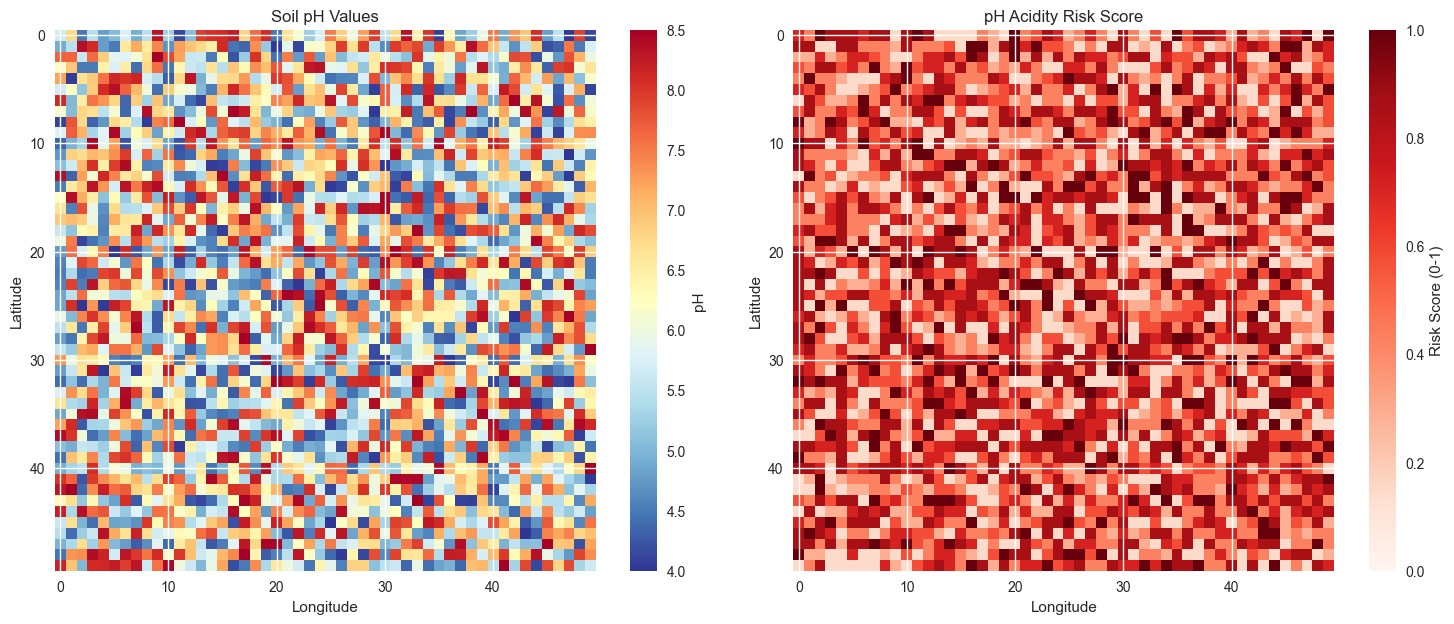

pH Risk Statistics:
  Mean: 0.571
  Std:  0.285
  High Risk Areas (>0.7): 1112 pixels


In [19]:
# Demonstrate pH classification with sample data
sample_ph = xr.DataArray(
    np.random.uniform(4.0, 8.5, (50, 50)),
    dims=['y', 'x'],
    coords={'y': np.linspace(-10, 10, 50), 'x': np.linspace(10, 40, 50)}
)

# Classify pH risk
ph_risk = analyzer.classify_soil_ph(sample_ph)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Raw pH values
im1 = ax1.imshow(sample_ph, cmap='RdYlBu_r', vmin=4, vmax=8.5)
ax1.set_title('Soil pH Values')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.colorbar(im1, ax=ax1, label='pH')

# pH risk score
im2 = ax2.imshow(ph_risk, cmap='Reds', vmin=0, vmax=1)
ax2.set_title('pH Acidity Risk Score')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.colorbar(im2, ax=ax2, label='Risk Score (0-1)')

plt.tight_layout()
plt.show()

print(f"pH Risk Statistics:")
print(f"  Mean: {ph_risk.mean().values:.3f}")
print(f"  Std:  {ph_risk.std().values:.3f}")
print(f"  High Risk Areas (>0.7): {(ph_risk > 0.7).sum().values} pixels")

## 3. Question 2: Future Moisture Stress Analysis

Analyze projected changes in soil moisture stress under climate change scenarios.

In [20]:
# Demonstrate climate stress analysis with sample data
# This would normally use ISIMIP climate projections

# Generate sample historical and future moisture data
np.random.seed(42)
years = np.arange(1990, 2051)
lat = np.linspace(-35, 15, 30)
lon = np.linspace(-20, 50, 40)

# Simulate declining moisture trend with variability
trend = np.linspace(0, -0.3, len(years))  # Declining moisture
noise = np.random.normal(0, 0.1, (len(years), len(lat), len(lon)))
base_moisture = 0.5 + 0.2 * np.sin(np.arange(len(years)) * 2 * np.pi / 10)  # Decadal cycle

moisture_data = xr.DataArray(
    base_moisture[:, np.newaxis, np.newaxis] + trend[:, np.newaxis, np.newaxis] + noise,
    dims=['time', 'lat', 'lon'],
    coords={'time': years, 'lat': lat, 'lon': lon}
)

print(f"Sample moisture data shape: {moisture_data.shape}")
print(f"Time range: {moisture_data.time.min().values} - {moisture_data.time.max().values}")

Sample moisture data shape: (61, 30, 40)
Time range: 1990 - 2050


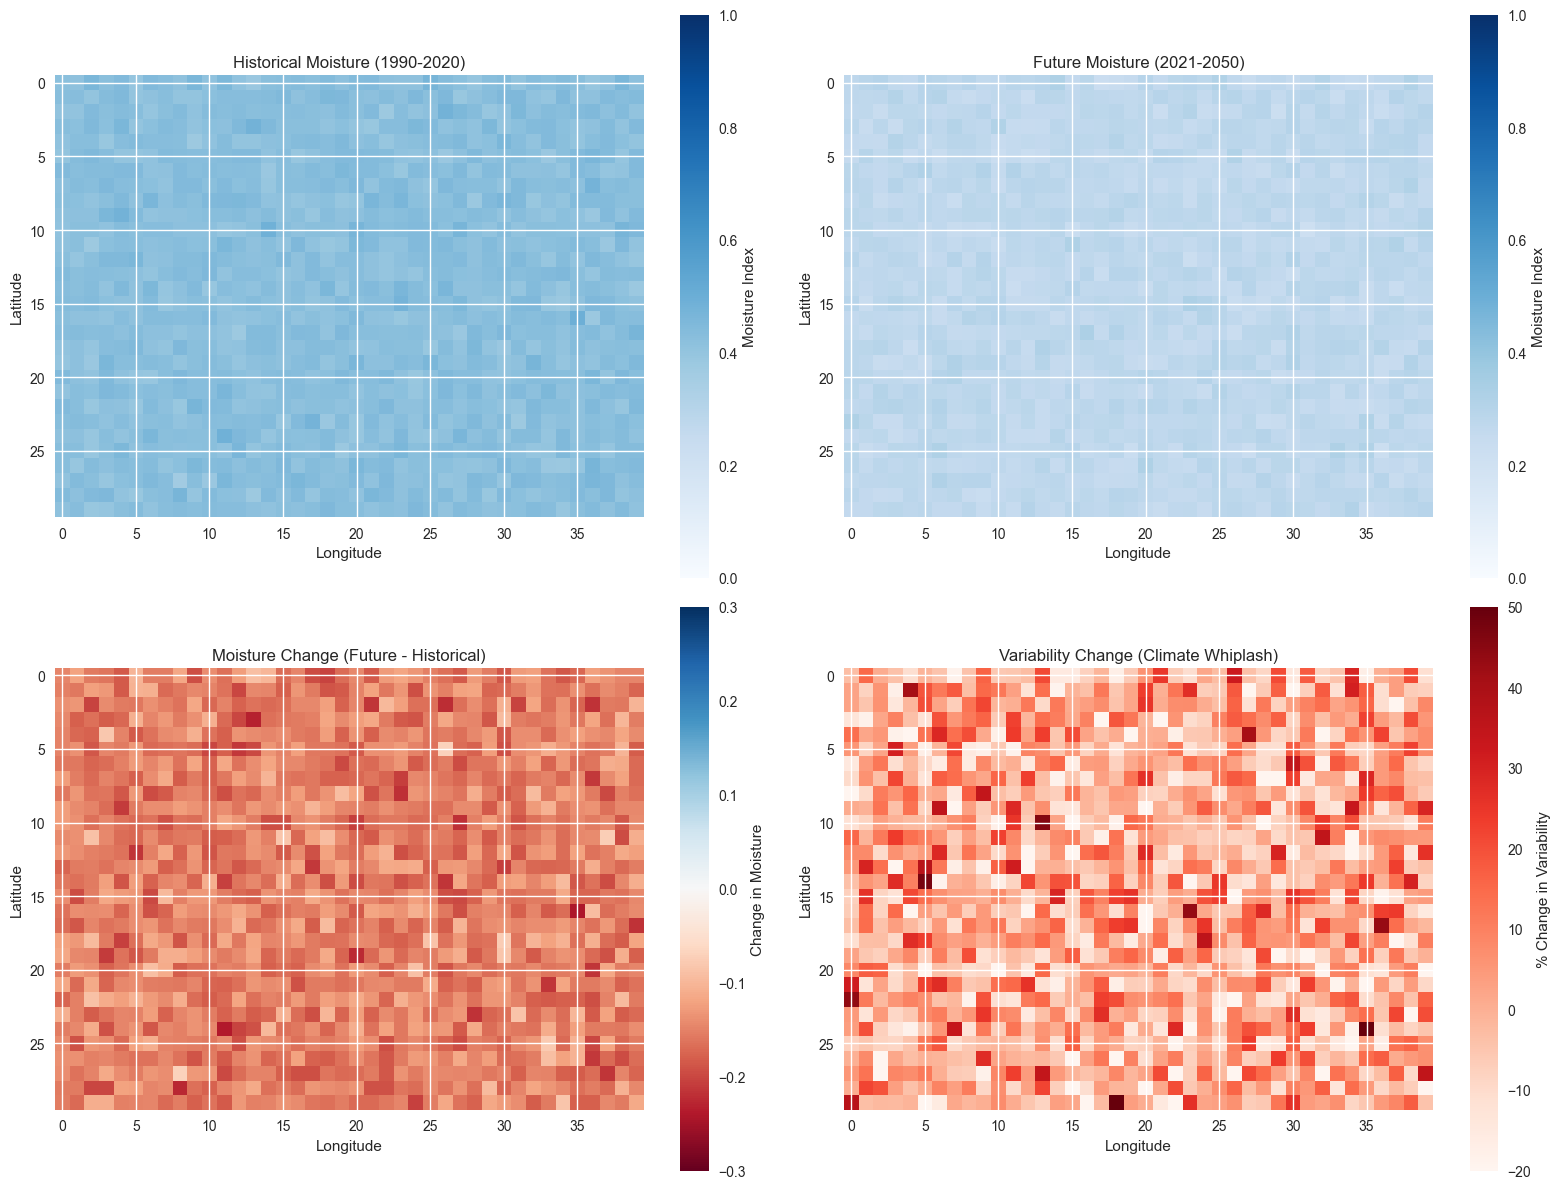


Moisture Stress Analysis:
  Mean moisture change: -0.152
  Areas with >10% drying: 1166 pixels
  Mean variability change: 1.9%


In [21]:
# Analyze moisture stress trends
# Calculate decadal means
historical_period = moisture_data.sel(time=slice(1990, 2020))
future_period = moisture_data.sel(time=slice(2021, 2050))

historical_mean = historical_period.mean('time')
future_mean = future_period.mean('time')
moisture_change = future_mean - historical_mean

# Calculate "climate whiplash" (inter-annual variability)
historical_std = historical_period.std('time')
future_std = future_period.std('time')
variability_change = (future_std - historical_std) / historical_std * 100  # Percent change

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Historical moisture
im1 = axes[0,0].imshow(historical_mean, cmap='Blues', vmin=0, vmax=1)
axes[0,0].set_title('Historical Moisture (1990-2020)')
plt.colorbar(im1, ax=axes[0,0], label='Moisture Index')

# Future moisture
im2 = axes[0,1].imshow(future_mean, cmap='Blues', vmin=0, vmax=1)
axes[0,1].set_title('Future Moisture (2021-2050)')
plt.colorbar(im2, ax=axes[0,1], label='Moisture Index')

# Moisture change
im3 = axes[1,0].imshow(moisture_change, cmap='RdBu', vmin=-0.3, vmax=0.3)
axes[1,0].set_title('Moisture Change (Future - Historical)')
plt.colorbar(im3, ax=axes[1,0], label='Change in Moisture')

# Variability change ("whiplash")
im4 = axes[1,1].imshow(variability_change, cmap='Reds', vmin=-20, vmax=50)
axes[1,1].set_title('Variability Change (Climate Whiplash)')
plt.colorbar(im4, ax=axes[1,1], label='% Change in Variability')

for ax in axes.flat:
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

print(f"\nMoisture Stress Analysis:")
print(f"  Mean moisture change: {moisture_change.mean().values:.3f}")
print(f"  Areas with >10% drying: {(moisture_change < -0.1).sum().values} pixels")
print(f"  Mean variability change: {variability_change.mean().values:.1f}%")

## 4. Question 3: Compound Risk Assessment

Combine soil health and climate stress data to identify compound risk hotspots.

Original shapes:
pH risk: (50, 50)
Moisture change: (30, 40)
Aligned climate stress: (50, 50)
Compound risk shape: (50, 50)


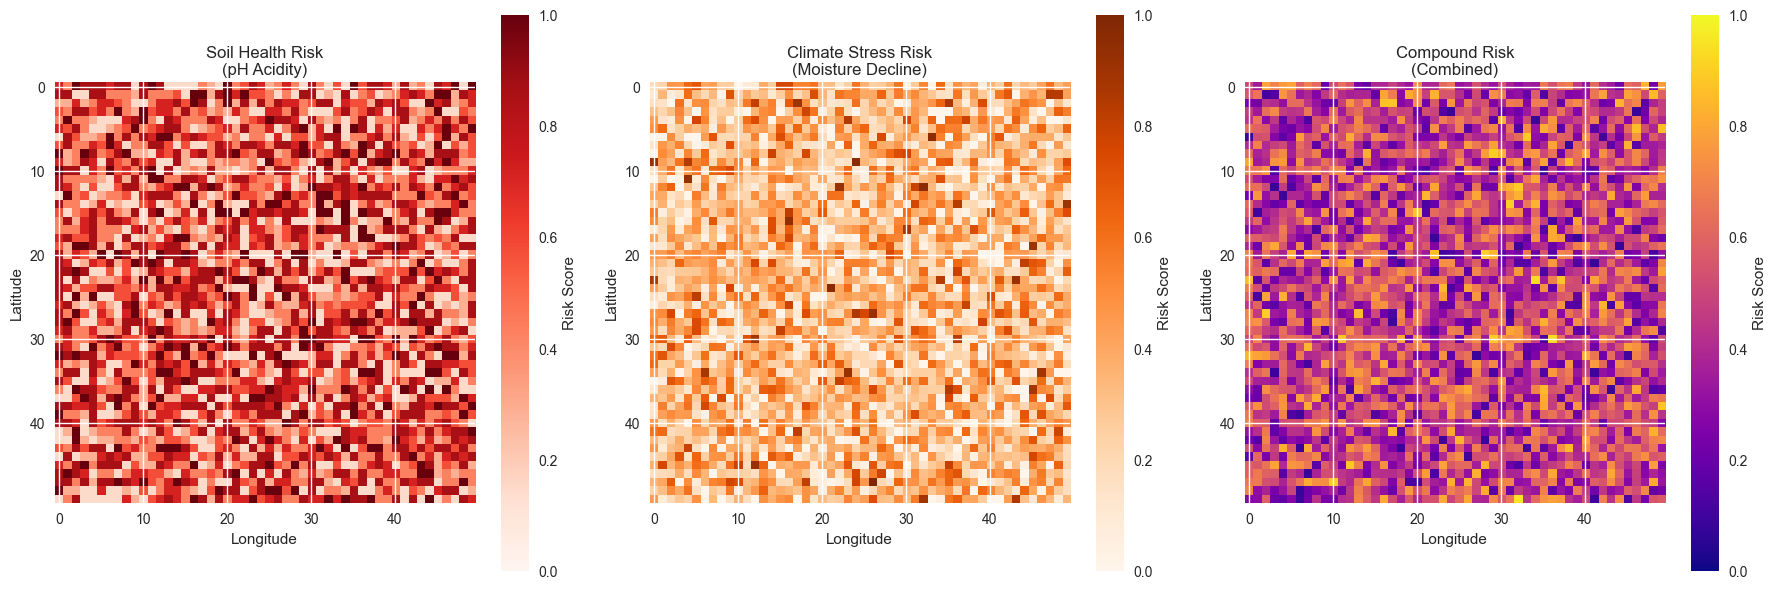


Compound Risk Classification:
  Low: 338 pixels (13.5%)
  Moderate: 951 pixels (38.0%)
  High: 1026 pixels (41.0%)
  Very High: 185 pixels (7.4%)


In [27]:
# Create sample compound risk assessment
# Resample climate data to match soil data grid for demonstration

# First, let's check the shapes to understand the issue
print("Original shapes:")
print(f"pH risk: {ph_risk.shape}")
print(f"Moisture change: {moisture_change.shape}")

# Create a 2D version of climate stress that matches pH risk dimensions
# We'll use the mean across lat/lon to create a representative 2D field
climate_stress_2d = abs(moisture_change.mean().values) * np.ones_like(ph_risk)

# Add some spatial variation to make it more realistic
np.random.seed(456)
climate_variation = np.random.normal(0, 0.1, ph_risk.shape)
climate_stress_2d = np.clip(climate_stress_2d + climate_variation, 0, 1)

# Convert to xarray to match ph_risk
climate_stress = xr.DataArray(
    climate_stress_2d,
    dims=ph_risk.dims,
    coords=ph_risk.coords
)

print(f"Aligned climate stress: {climate_stress.shape}")

# Normalize climate stress to 0-1 scale
climate_stress_norm = (climate_stress - climate_stress.min()) / (climate_stress.max() - climate_stress.min())

# Calculate compound risk using weighted combination
# Weights: soil health (60%) + climate stress (40%)
compound_risk = 0.6 * ph_risk + 0.4 * climate_stress_norm

# Classify risk levels
risk_classes = analyzer.classify_risk_levels(compound_risk)

print(f"Compound risk shape: {compound_risk.shape}")

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Soil health risk
im1 = axes[0].imshow(ph_risk, cmap='Reds', vmin=0, vmax=1)
axes[0].set_title('Soil Health Risk\n(pH Acidity)')
plt.colorbar(im1, ax=axes[0], label='Risk Score')

# Climate stress
im2 = axes[1].imshow(climate_stress_norm, cmap='Oranges', vmin=0, vmax=1)
axes[1].set_title('Climate Stress Risk\n(Moisture Decline)')
plt.colorbar(im2, ax=axes[1], label='Risk Score')

# Compound risk
im3 = axes[2].imshow(compound_risk, cmap='plasma', vmin=0, vmax=1)
axes[2].set_title('Compound Risk\n(Combined)')
plt.colorbar(im3, ax=axes[2], label='Risk Score')

for ax in axes:
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

# Risk classification summary
risk_counts = {}
risk_names = ['Low', 'Moderate', 'High', 'Very High']
for i, name in enumerate(risk_names, 1):
    count = (risk_classes == i).sum().values
    risk_counts[name] = count

print("\nCompound Risk Classification:")
for name, count in risk_counts.items():
    percentage = count / risk_classes.size * 100
    print(f"  {name}: {count} pixels ({percentage:.1f}%)")

## 5. Questions 4 & 5: Agricultural Exposure and Solutions

Quantify agricultural exposure to risks and identify suitable management practices.

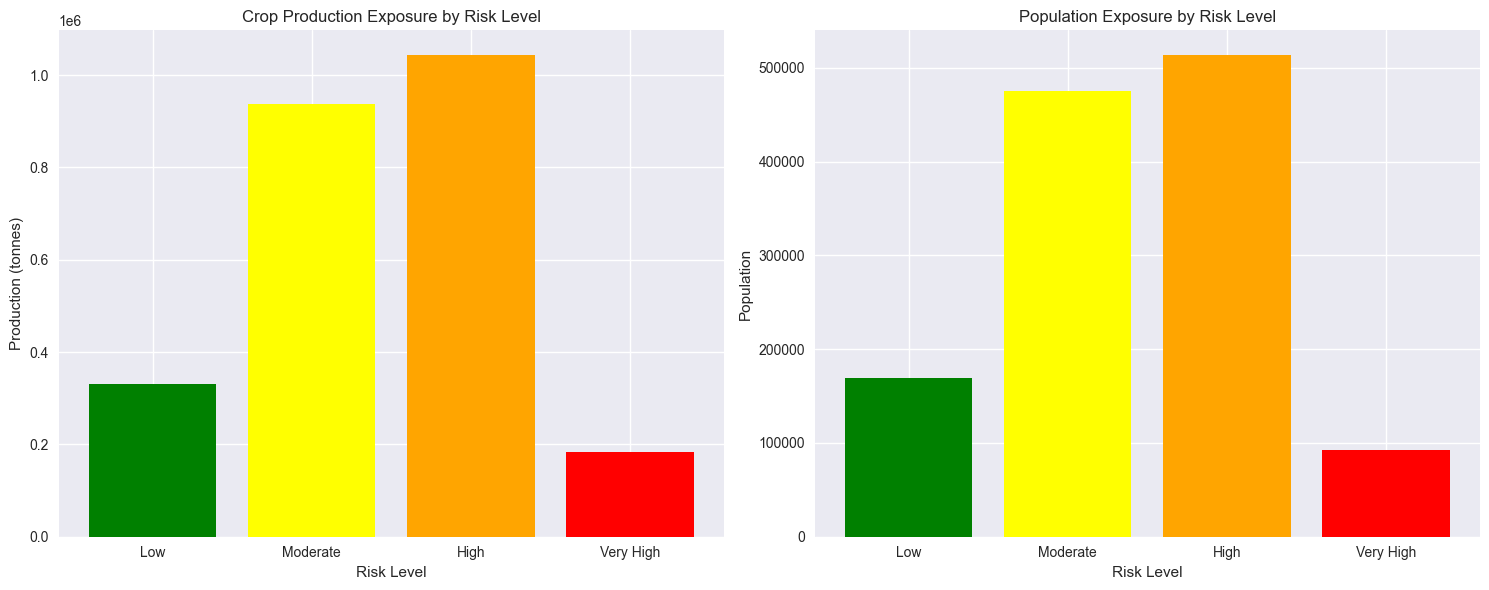


Agricultural Exposure Summary:
  Total crop production: 2,495,457 tonnes
  Production in high/very high risk areas: 1,227,532 tonnes (49.2%)
  Total population: 1,251,317 people
  Population in high/very high risk areas: 606,789 people (48.5%)


In [28]:
# Simulate agricultural exposure analysis
# This would normally use MapSPAM crop data and GLW livestock data

# Create sample crop production data aligned with risk assessment
np.random.seed(123)
crop_production = xr.DataArray(
    np.random.exponential(1000, compound_risk.shape),  # Production in tonnes
    dims=compound_risk.dims,
    coords=compound_risk.coords
)

# Simulate population data
population = xr.DataArray(
    np.random.poisson(500, compound_risk.shape),  # People per grid cell
    dims=compound_risk.dims,
    coords=compound_risk.coords
)

# Calculate exposure statistics by risk level
exposure_stats = {}
for i, risk_level in enumerate(['Low', 'Moderate', 'High', 'Very High'], 1):
    mask = risk_classes == i
    
    total_production = crop_production.where(mask).sum().values
    total_population = population.where(mask).sum().values
    area_count = mask.sum().values
    
    exposure_stats[risk_level] = {
        'production_tonnes': total_production,
        'population': total_population,
        'area_pixels': area_count
    }

# Create exposure visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Agricultural production exposure
risk_levels = list(exposure_stats.keys())
production_values = [exposure_stats[level]['production_tonnes'] for level in risk_levels]
population_values = [exposure_stats[level]['population'] for level in risk_levels]

x_pos = np.arange(len(risk_levels))

bars1 = axes[0].bar(x_pos, production_values, color=['green', 'yellow', 'orange', 'red'])
axes[0].set_title('Crop Production Exposure by Risk Level')
axes[0].set_xlabel('Risk Level')
axes[0].set_ylabel('Production (tonnes)')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(risk_levels)

# Population exposure
bars2 = axes[1].bar(x_pos, population_values, color=['green', 'yellow', 'orange', 'red'])
axes[1].set_title('Population Exposure by Risk Level')
axes[1].set_xlabel('Risk Level')
axes[1].set_ylabel('Population')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(risk_levels)

plt.tight_layout()
plt.show()

# Print exposure summary
print("\nAgricultural Exposure Summary:")
total_production = sum(stats['production_tonnes'] for stats in exposure_stats.values())
total_population = sum(stats['population'] for stats in exposure_stats.values())

high_risk_production = exposure_stats['High']['production_tonnes'] + exposure_stats['Very High']['production_tonnes']
high_risk_population = exposure_stats['High']['population'] + exposure_stats['Very High']['population']

print(f"  Total crop production: {total_production:,.0f} tonnes")
print(f"  Production in high/very high risk areas: {high_risk_production:,.0f} tonnes ({high_risk_production/total_production*100:.1f}%)")
print(f"  Total population: {total_population:,.0f} people")
print(f"  Population in high/very high risk areas: {high_risk_population:,.0f} people ({high_risk_population/total_population*100:.1f}%)")

### Solutions Framework

Sustainable Land Management Solutions by Risk Type:

Soil Acidity:
  • Liming
    - Effectiveness: High
    - Cost: Medium
    - Timeframe: 1-2 years
  • Organic matter application
    - Effectiveness: Medium
    - Cost: Low
    - Timeframe: 2-3 years
  • Agroforestry
    - Effectiveness: Medium
    - Cost: Low
    - Timeframe: 3-5 years

Low Soc:
  • Cover cropping
    - Effectiveness: High
    - Cost: Low
    - Timeframe: 2-3 years
  • Composting
    - Effectiveness: High
    - Cost: Medium
    - Timeframe: 1-2 years
  • Conservation tillage
    - Effectiveness: Medium
    - Cost: Low
    - Timeframe: 1-2 years

Erosion:
  • Contour farming
    - Effectiveness: High
    - Cost: Low
    - Timeframe: Immediate
  • Terracing
    - Effectiveness: Very High
    - Cost: High
    - Timeframe: 1-2 years
  • Grass strips
    - Effectiveness: Medium
    - Cost: Low
    - Timeframe: 1 year

Moisture Stress:
  • Zai pits
    - Effectiveness: High
    - Cost: Low
    - Timeframe: 1 year
  • Mulch

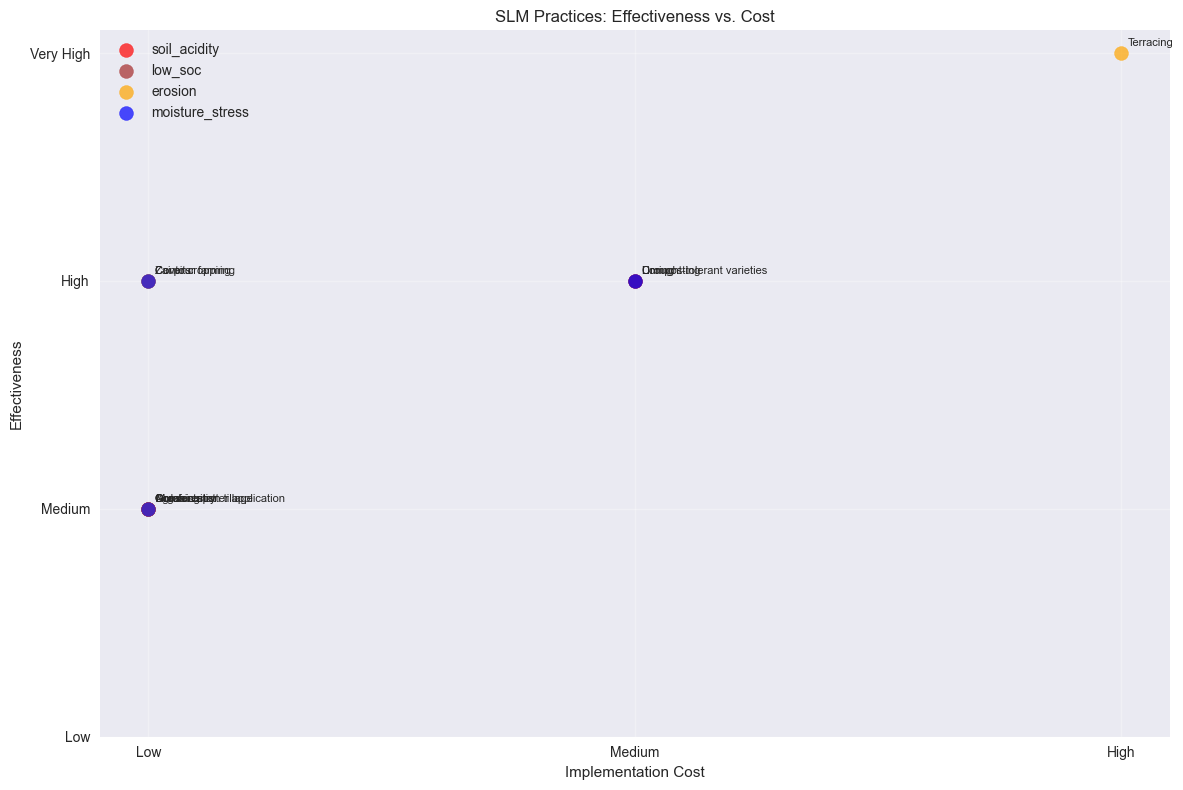

In [29]:
# Demonstrate solutions matching framework
# This would normally integrate with WOCAT database

# Sample sustainable land management practices
slm_practices = {
    'soil_acidity': [
        {'name': 'Liming', 'effectiveness': 'High', 'cost': 'Medium', 'timeframe': '1-2 years'},
        {'name': 'Organic matter application', 'effectiveness': 'Medium', 'cost': 'Low', 'timeframe': '2-3 years'},
        {'name': 'Agroforestry', 'effectiveness': 'Medium', 'cost': 'Low', 'timeframe': '3-5 years'}
    ],
    'low_soc': [
        {'name': 'Cover cropping', 'effectiveness': 'High', 'cost': 'Low', 'timeframe': '2-3 years'},
        {'name': 'Composting', 'effectiveness': 'High', 'cost': 'Medium', 'timeframe': '1-2 years'},
        {'name': 'Conservation tillage', 'effectiveness': 'Medium', 'cost': 'Low', 'timeframe': '1-2 years'}
    ],
    'erosion': [
        {'name': 'Contour farming', 'effectiveness': 'High', 'cost': 'Low', 'timeframe': 'Immediate'},
        {'name': 'Terracing', 'effectiveness': 'Very High', 'cost': 'High', 'timeframe': '1-2 years'},
        {'name': 'Grass strips', 'effectiveness': 'Medium', 'cost': 'Low', 'timeframe': '1 year'}
    ],
    'moisture_stress': [
        {'name': 'Zai pits', 'effectiveness': 'High', 'cost': 'Low', 'timeframe': '1 year'},
        {'name': 'Mulching', 'effectiveness': 'Medium', 'cost': 'Low', 'timeframe': 'Immediate'},
        {'name': 'Drought-tolerant varieties', 'effectiveness': 'High', 'cost': 'Medium', 'timeframe': '1-2 years'}
    ]
}

# Create solutions summary
print("Sustainable Land Management Solutions by Risk Type:\n")

for risk_type, practices in slm_practices.items():
    print(f"{risk_type.replace('_', ' ').title()}:")
    for practice in practices:
        print(f"  • {practice['name']}")
        print(f"    - Effectiveness: {practice['effectiveness']}")
        print(f"    - Cost: {practice['cost']}")
        print(f"    - Timeframe: {practice['timeframe']}")
    print()

# Create a simple solutions effectiveness chart
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for plotting
all_practices = []
effectiveness_scores = []
cost_scores = []
risk_types = []

effectiveness_map = {'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
cost_map = {'Low': 1, 'Medium': 2, 'High': 3}

for risk_type, practices in slm_practices.items():
    for practice in practices:
        all_practices.append(practice['name'])
        effectiveness_scores.append(effectiveness_map[practice['effectiveness']])
        cost_scores.append(cost_map[practice['cost']])
        risk_types.append(risk_type)

# Create scatter plot
colors = {'soil_acidity': 'red', 'low_soc': 'brown', 'erosion': 'orange', 'moisture_stress': 'blue'}
for i, (practice, eff, cost, risk_type) in enumerate(zip(all_practices, effectiveness_scores, cost_scores, risk_types)):
    ax.scatter(cost, eff, c=colors[risk_type], s=100, alpha=0.7, label=risk_type if practice == slm_practices[risk_type][0]['name'] else "")
    ax.annotate(practice, (cost, eff), xytext=(5, 5), textcoords='offset points', fontsize=8)

ax.set_xlabel('Implementation Cost')
ax.set_ylabel('Effectiveness')
ax.set_title('SLM Practices: Effectiveness vs. Cost')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Low', 'Medium', 'High'])
ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels(['Low', 'Medium', 'High', 'Very High'])
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 6. Summary and Next Steps

This notebook provides a foundation for the complete analysis. Next steps include:

### Immediate Actions
1. **Download Real Data**: Use the data downloader to acquire actual datasets
2. **Run Full Analysis**: Execute complete soil health and climate analysis
3. **Create Interactive Visualizations**: Develop Observable notebook components

### Advanced Development
1. **Climate Model Integration**: Process ISIMIP climate projections
2. **Agricultural Data Integration**: Include MapSPAM and livestock data
3. **WOCAT Solutions Database**: Connect to real solutions database
4. **Policy Framework Integration**: Add SoiLEX policy context

### Observable Notebook Features
1. **Interactive Maps**: Leaflet/D3.js for geographic visualization
2. **User Controls**: Filters for countries, time periods, scenarios
3. **Dashboard Components**: Summary statistics and exposure metrics
4. **Solutions Explorer**: Risk-solution matching interface

See the project documentation for detailed implementation guidance.

In [31]:
# Save analysis results for Observable notebook
output_dir = config.PROCESSED_DATA_PATH / 'notebook_demo'
output_dir.mkdir(exist_ok=True)

# Save sample data as GeoJSON for web visualization
import json

# Convert exposure_stats to JSON-serializable format
json_exposure_stats = {}
for risk_level, stats in exposure_stats.items():
    json_exposure_stats[risk_level] = {
        'production_tonnes': float(stats['production_tonnes']),
        'population': int(stats['population']),
        'area_pixels': int(stats['area_pixels'])
    }

# Convert risk data to simple format
risk_summary = {
    'total_pixels': int(compound_risk.size),
    'mean_risk': float(compound_risk.mean().values),
    'high_risk_percentage': float((compound_risk > 0.7).sum().values / compound_risk.size * 100),
    'exposure_stats': json_exposure_stats,
    'risk_classification': {
        'low': int(risk_counts['Low']),
        'moderate': int(risk_counts['Moderate']),
        'high': int(risk_counts['High']),
        'very_high': int(risk_counts['Very High'])
    }
}

with open(output_dir / 'risk_summary.json', 'w') as f:
    json.dump(risk_summary, f, indent=2)

print(f"Analysis summary saved to: {output_dir / 'risk_summary.json'}")
print("\nSummary of key findings:")
print(f"  • {risk_summary['high_risk_percentage']:.1f}% of area is at high compound risk")
print(f"  • {json_exposure_stats['High']['production_tonnes'] + json_exposure_stats['Very High']['production_tonnes']:,.0f} tonnes of crops at risk")
print(f"  • {json_exposure_stats['High']['population'] + json_exposure_stats['Very High']['population']:,} people in high-risk areas")
print("\n🎉 Ready for Observable notebook development!")

Analysis summary saved to: data\processed\notebook_demo\risk_summary.json

Summary of key findings:
  • 14.1% of area is at high compound risk
  • 1,227,532 tonnes of crops at risk
  • 606,789 people in high-risk areas

🎉 Ready for Observable notebook development!
